# TITANIC

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

Let's look at our dataset

In [37]:
data_train = pd.read_csv("train.csv") 
df = pd.DataFrame(data_train)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
print("We have {} passengers in our training set".format(len(df)))

We have 891 passengers in our training set


We want to check how many null values we have

In [39]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We see that we don't know most of the passengers' cabin numbers. So we don't want to train our model with that information.
So we are going to drop our "Cabin" column from our dataframe

In [40]:
df = df.drop('Cabin',axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


We also saw that there are 177 NaN values under the "Age" column. We want to turn them into median age value.

In [41]:
print("Median age value in our dataframe is {}".format(df['Age'].median()))
df['Age'].fillna(df['Age'].median(), inplace=True)
df.head()

Median age value in our dataframe is 28.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


We also saw that there are 2 NaN values under the "Embarked" column. We want to change them to the most frequent Embarked value

In [42]:
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace = True)

# Let's check if we still have any NaN values
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

We want all of our information to be in between 0 and 4 because we want to keep our featuers in the same range. Since we want to do that, we have to categorize "Sex", "Fare, "Embarked", and "Age" columns. Let's start with "Age"

We will divide ages into 5 categories:

- Child (0-18): 0
- Young (18-28): 1
- Adult (28-40): 2
- Middle Age (40-60): 3
- Senior (60+): 4

In [43]:
df.loc[df['Age'] <= 18, 'Age'] = 0
df.loc[(df['Age'] > 18) & (df['Age'] <= 28), 'Age'] = 1
df.loc[(df['Age'] > 28) & (df['Age'] <= 40), 'Age'] = 2
df.loc[(df['Age'] > 40) & (df['Age'] <= 60), 'Age'] = 3
df.loc[df['Age'] > 60, 'Age'] = 4
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,S


Let's look at "Fare" column now

In [44]:
df['FareBand'] = pd.qcut(df['Fare'], 5)
print (df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())
# This piece of code is from https://www.kaggle.com/michaelabehsera/titanic-solution-a-beginner-s-guide

            FareBand  Survived
0    (-0.001, 7.854]  0.217877
1      (7.854, 10.5]  0.201087
2     (10.5, 21.679]  0.424419
3   (21.679, 39.688]  0.444444
4  (39.688, 512.329]  0.642045


In [45]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,7.2500,S,"(-0.001, 7.854]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,71.2833,C,"(39.688, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,7.9250,S,"(7.854, 10.5]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,53.1000,S,"(39.688, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,8.0500,S,"(7.854, 10.5]"


Now we are going to categorize "Fare" column

In [46]:
df.loc[df['Fare'] <= 7.854, 'Fare'] = 0
df.loc[(df['Fare'] > 7.854) & (df['Fare'] <= 10.5), 'Fare'] = 1
df.loc[(df['Fare'] > 10.5) & (df['Fare'] <= 21.679), 'Fare'] = 2
df.loc[(df['Fare'] > 21.679) & (df['Fare'] <= 39.688), 'Fare'] = 3
df.loc[df['Fare'] > 39.688, 'Fare'] = 4
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",male,1.0,1,0,A/5 21171,0.0,S,"(-0.001, 7.854]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2.0,1,0,PC 17599,4.0,C,"(39.688, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",female,1.0,0,0,STON/O2. 3101282,1.0,S,"(7.854, 10.5]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,2.0,1,0,113803,4.0,S,"(39.688, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",male,2.0,0,0,373450,1.0,S,"(7.854, 10.5]"


Next we want to categorize our "Sex" column. (0 for male, 1 for female)

In [47]:
df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,0.0,S,"(-0.001, 7.854]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,1,0,PC 17599,4.0,C,"(39.688, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",1,1.0,0,0,STON/O2. 3101282,1.0,S,"(7.854, 10.5]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,4.0,S,"(39.688, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,1.0,S,"(7.854, 10.5]"


Let's do the same for "Embarked" column as well

In [48]:
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FareBand
0,1,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,A/5 21171,0.0,0,"(-0.001, 7.854]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,1,0,PC 17599,4.0,1,"(39.688, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",1,1.0,0,0,STON/O2. 3101282,1.0,0,"(7.854, 10.5]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,113803,4.0,0,"(39.688, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",0,2.0,0,0,373450,1.0,0,"(7.854, 10.5]"


Now, let's look at features closely to see if they are related to probability of survival

Let's first start with "Sex" column

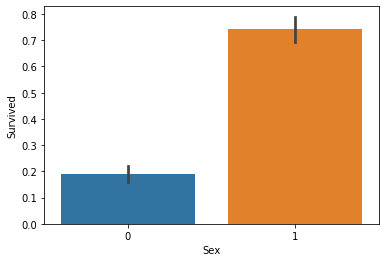

In [49]:
sns.barplot(x='Sex', y='Survived', data=df)

We see that females are more likely to survived than males. Let's look at other columns' relationship with survival rate

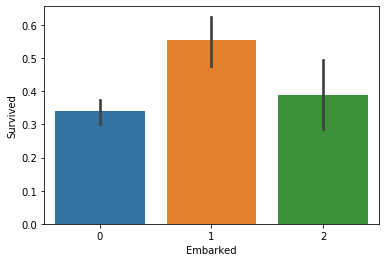

In [50]:
sns.barplot(x='Embarked', y='Survived', data=df)

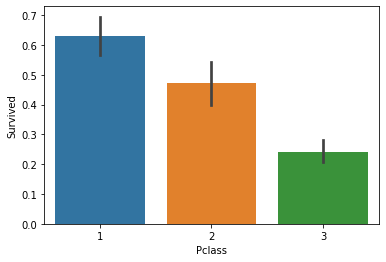

In [51]:
sns.barplot(x='Pclass', y='Survived', data=df)

# Feature Selection and Defining X_train and y_train

In [52]:
X_train = df.drop(['Survived','Name','Ticket','FareBand','PassengerId'], axis=1)
y_train = df['Survived']
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,1.0,1,0,0.0,0
1,1,1,2.0,1,0,4.0,1
2,3,1,1.0,0,0,1.0,0
3,1,1,2.0,1,0,4.0,0
4,3,0,2.0,0,0,1.0,0


# Reading test file and making it similar to our training set

In [53]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Let's drop all the features we don't want

In [54]:
test.drop(['Name', 'Ticket','Cabin'], axis=1, inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [55]:
X_test = test.drop("PassengerId", axis=1).copy()
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


We have to categorize same columns as we did with training set before

In [56]:
# Age

X_test['Age'].fillna(df['Age'].median(), inplace=True)
X_test.loc[X_test['Age'] <= 18, 'Age'] = 0
X_test.loc[(X_test['Age'] > 18) & (X_test['Age'] <= 28), 'Age'] = 1
X_test.loc[(X_test['Age'] > 28) & (X_test['Age'] <= 40), 'Age'] = 2
X_test.loc[(X_test['Age'] > 40) & (X_test['Age'] <= 60), 'Age'] = 3
X_test.loc[X_test['Age'] > 60, 'Age'] = 4

# Sex

X_test['Sex'] = X_test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

# Fare

X_test.loc[X_test['Fare'] <= 7.854, 'Fare'] = 0
X_test.loc[(X_test['Fare'] > 7.854) & (X_test['Fare'] <= 10.5), 'Fare'] = 1
X_test.loc[(X_test['Fare'] > 10.5) & (X_test['Fare'] <= 21.679), 'Fare'] = 2
X_test.loc[(X_test['Fare'] > 21.679) & (X_test['Fare'] <= 39.688), 'Fare'] = 3
X_test.loc[X_test['Fare'] > 39.688, 'Fare'] = 4
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].median())

# Embarked

X_test['Embarked'] = X_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)


In [57]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,2.0,0,0,0.0,2
1,3,1,3.0,1,0,0.0,0
2,2,0,4.0,0,0,1.0,2
3,3,0,1.0,0,0,1.0,0
4,3,1,1.0,1,1,2.0,0


In [58]:
X_train.shape

(891, 7)

In [59]:
X_test.shape

(418, 7)

# MODEL TRAINING AND PREDICTIONS

# Let's try Random Forest first

In [65]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
accuracy = round(clf.score(X_train, y_train) * 100, 2)
print(accuracy)

88.89


Great! We have nearly 89% accuracy with this Random Forest model.

In [61]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# XGBOOST

In [68]:
# THIS CODE IS FROM https://www.kaggle.com/simulacra/titanic-with-xgboost

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(8, 20),
    'max_depth': range(6, 10),
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1]
}

# Instantiate the regressor: gbm
gbm = XGBClassifier(n_estimators=10)

# Perform random search: grid_mse
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                    estimator = gbm, scoring = "accuracy", 
                                    verbose = 1, n_iter = 50, cv = 4)


# Fit randomized_mse to the data
xgb_random.fit(X_train, y_train)
print("Best accuracy found: ", xgb_random.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best accuracy found:  0.8181887043994667


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished


In [71]:
predictions = xgb_random.predict(X_test)
predictions

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

I got 0.74 score on Kaggle with RandomForest Classifier and I got 0.76 score with XGBoost.

# SUBMISSION

In [72]:
submission = pd.DataFrame({"PassengerId" : test['PassengerId'],
                           "Survived" : predictions})
submission.to_csv('submission.csv', index=False)